# Visualization

* find a way so that you select one pixel in the original image and see which pixels in the reconstructed image are affected by it -> this is like taking one row/column of the attention matrix
* you can take an off the shelf segmentation model and with that create a map of the original image (like color blocks thanks to majority voting) -> then see how does the model perform on that


# Improvements -> IDEA
* make it so that you're not using cutout but extracting them from 360 -> search for preexisting function
* you can compute the n_patches x n_patches distance matrix between the positional embeddings of both images
    - this means that for the aerial image you'll have a 64 x 64 matrix and for the ground image a 256 x 256
    - then you can binarize this matrix by setting all values to 0 except for some elements which will be 1 according to a criterion
        - top k closest elements
        - distance between the embeddings is less than a threshold like 8 pixels

* let's consider the G2A attention matrix to be a 64 x 256 matrix
    - you should normalize it
    - you should compute the cosine similarity of this attention matrix by computing the matmul with its transpose
    - the cosine similarity matrix will be a 64 x 64 matrix

* then, the loss on the attention map is given by the cosine similarity multiplied by the binarized distance matrix
    - this loss should be added to the reconstruction loss

* contrastive loss 

In [1]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import sys
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import os
import argparse
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import ImageFile
from tqdm import tqdm
import numpy as np
from dataset import PairedImagesDataset, sample_paired_images
from model import CroDINO, Dinov2Matcher, CosineSimilarityLoss, get_combined_embedding_visualization_all

In [2]:
# Sample paired images
dataset_path = '/home/lrusso/cvusa'
train_filenames, val_filenames = sample_paired_images(dataset_path, sample_percentage=0.2, split_ratio=0.8, groundtype='cutouts')

# Settings
image_size = 224
aerial_scaling = 4
provide_paths = False
BATCH_SIZE = 1

transform_ground = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop((image_size, image_size)),
    transforms.ToTensor()
])

transform_aerial = transforms.Compose([
    transforms.Resize((image_size*aerial_scaling, image_size*aerial_scaling)),
    transforms.CenterCrop((image_size, image_size)),
    transforms.ToTensor()
])

# Instantiate the dataset and dataloader
paired_dataset = PairedImagesDataset(train_filenames, transform_aerial=transform_aerial, transform_ground=transform_ground)
data_loader = DataLoader(paired_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define the new model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the Models
repo_name="facebookresearch/dinov2"
model_name="dinov2_vitb14"
model = CroDINO(repo_name, model_name, pretrained=True).to(device)

pretrained_crodino = False
if pretrained_crodino:
    # Load the trained model state dict
    model_path = 'models/all_finetuned/best_model_epoch_3.pth'
    model_state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(model_state_dict)
    model.eval()

# Load a single pair of images
ground_image, aerial_image = next(iter(data_loader))
ground_image = ground_image.to(device)
aerial_image = aerial_image.to(device)

Using device: cuda


Using cache found in /home/lrusso/.cache/torch/hub/facebookresearch_dinov2_main


In [3]:
# Compute the output of the model
ground_tokens, aerial_tokens, attention = model(ground_image, aerial_image, debug=True)

print("attention shape: ", attention.shape)
print("ground tokens shape:", ground_tokens.shape)
print("aerial tokens shape:", aerial_tokens.shape)

# Visualize the final single-head attention layer
attention = attention.mean(dim=1)  # average across heads only
print("attention shape: ", attention.shape)

# Calculate the number of patches for ground and aerial images
num_patches_ground = (ground_image.shape[-1] // model.patch_size) * (ground_image.shape[-2] // model.patch_size)
num_patches_aerial = (aerial_image.shape[-1] // model.patch_size) * (aerial_image.shape[-2] // model.patch_size)

# Remove the first row and column
attention = attention[:, 1:, 1:]

# Remove the row and column corresponding to 1+num_patches_ground
attention = torch.cat((attention[:, :num_patches_ground-1, :], attention[:, num_patches_ground:, :]), dim=1)
attention = torch.cat((attention[:, :, :num_patches_ground-1], attention[:, :, num_patches_ground:]), dim=2)

# Retrieve Cross Attention
cross_attention_A2G = attention[:, :num_patches_ground, num_patches_ground:]
cross_attention_G2A = attention[:, num_patches_ground:, :num_patches_ground]
print("num_patches_ground: ", num_patches_ground)
print("num_patches_aerial: ", num_patches_aerial)
print("cross_attention_G2A shape: ", cross_attention_G2A.shape)
print("cross_attention_A2G shape: ", cross_attention_A2G.shape)

# Reconstruct the images from the tokens
reconstructed_aerial = torch.matmul(cross_attention_G2A, ground_tokens)
reconstructed_ground = torch.matmul(cross_attention_A2G, aerial_tokens)
# reconstructed_aerial = torch.matmul(cross_attention_A2G, ground_tokens)
# reconstructed_ground = torch.matmul(cross_attention_G2A, aerial_tokens)    # you should try training in different combinations
print("reconstructed_ground shape: ", reconstructed_ground.shape)
print("reconstructed_aerial shape: ", reconstructed_aerial.shape)

# Normalize the reconstructed images
reconstructed_ground = model.norm(reconstructed_ground)
reconstructed_aerial = model.norm(reconstructed_aerial)


# TODO: do the dummy test - if it does not work with identity matrix, then why would it work with the actual tokens?
reconstructed_ground = np.eye(ground_tokens.shape[1])
reconstructed_aerial = np.eye(aerial_tokens.shape[1])

# Compute Loss
# criterion = nn.MSELoss()
criterion = CosineSimilarityLoss()
loss_ground = criterion(reconstructed_ground, ground_tokens)
loss_aerial = criterion(reconstructed_aerial, aerial_tokens)
print("Ground Loss: ", loss_ground.item())
print("Aerial Loss: ", loss_aerial.item())
print("Total loss: ", loss_ground.item() + loss_aerial.item())

# Convert tensors to numpy
cross_attention_G2A = cross_attention_G2A.cpu().detach().numpy()
cross_attention_A2G = cross_attention_A2G.cpu().detach().numpy()

# Convert images to numpy for visualization
ground_image_np = ground_image.squeeze().permute(1, 2, 0).detach().cpu().numpy()
aerial_image_np = aerial_image.squeeze().permute(1, 2, 0).detach().cpu().numpy()

# Plot the ground image and aerial image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(ground_image_np)
ax[0].set_title("Ground Image")
ax[0].axis('off')
ax[1].imshow(aerial_image_np)
ax[1].set_title("Aerial Image")
ax[1].axis('off')
plt.show()

# Determine common vmin and vmax for color scales
vmin = min(cross_attention_G2A.min(), cross_attention_A2G.min())
vmax = max(cross_attention_G2A.max(), cross_attention_A2G.max())

# Plot the cross-attention maps with common color scale
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
img0 = ax[0].imshow(cross_attention_G2A.squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)
ax[0].set_title("Cross Attention: Ground to Aerial")
ax[0].set_xlabel("Aerial Tokens")
ax[0].set_ylabel("Ground Tokens")
fig.colorbar(img0, ax=ax[0])
img1 = ax[1].imshow(cross_attention_A2G.squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)
ax[1].set_title("Cross Attention: Aerial to Ground")
ax[1].set_xlabel("Ground Tokens")
ax[1].set_ylabel("Aerial Tokens")
fig.colorbar(img1, ax=ax[1])
plt.show()

# Visualize the whole attention map with common color scale
plt.imshow(attention.squeeze().detach().cpu().numpy(), cmap='viridis', vmin=vmin, vmax=vmax)
plt.title("Attention Map")
plt.xlabel("Tokens")
plt.ylabel("Tokens")
plt.colorbar()
plt.show()

x1_img shape:  torch.Size([1, 3, 224, 224])
x2_img shape:  torch.Size([1, 3, 224, 224])
x1_dino shape:  torch.Size([1, 256, 768])
x2_dino shape:  torch.Size([1, 256, 768])
attention shape:  torch.Size([1, 1, 514, 514])
ground tokens shape: torch.Size([1, 256, 768])
aerial tokens shape: torch.Size([1, 256, 768])
attention shape:  torch.Size([1, 514, 514])
num_patches_ground:  256
num_patches_aerial:  256
cross_attention_G2A shape:  torch.Size([1, 256, 256])
cross_attention_A2G shape:  torch.Size([1, 256, 256])
reconstructed_ground shape:  torch.Size([1, 256, 768])
reconstructed_aerial shape:  torch.Size([1, 256, 768])


TypeError: cosine_similarity(): argument 'x1' (position 1) must be Tensor, not numpy.ndarray

Using cache found in /home/lrusso/.cache/torch/hub/facebookresearch_dinov2_main


ground_image shape: torch.Size([1, 3, 224, 224])
aerial_image shape: torch.Size([1, 3, 224, 224])
tokens_1 shape: (256, 768)
tokens_2 shape: (256, 768)
grid_size1: (16, 16)
grid_size2: (16, 16)
grid_size2_reduced: (16, 16)
resize_scale1: 1.0
resize_scale2: 1.0
tokens1.shape (256, 768)
tokens2.shape (256, 768)
reduced_tokens.shape (512, 3)
tokens1.shape (256, 768)
tokens2.shape (256, 768)
reduced_tokens.shape (512, 3)
tokens_1.shape (256, 768)
tokens_2.shape (256, 768)
tokens_3.shape (256, 768)
tokens_4.shape (256, 768)
reduced_tokens.shape (1024, 3)
rgbimg1 shape (256, 3)
rgbimg2 shape (256, 3)
rgbimg3 shape (256, 3)
rgbimg4 shape (256, 3)


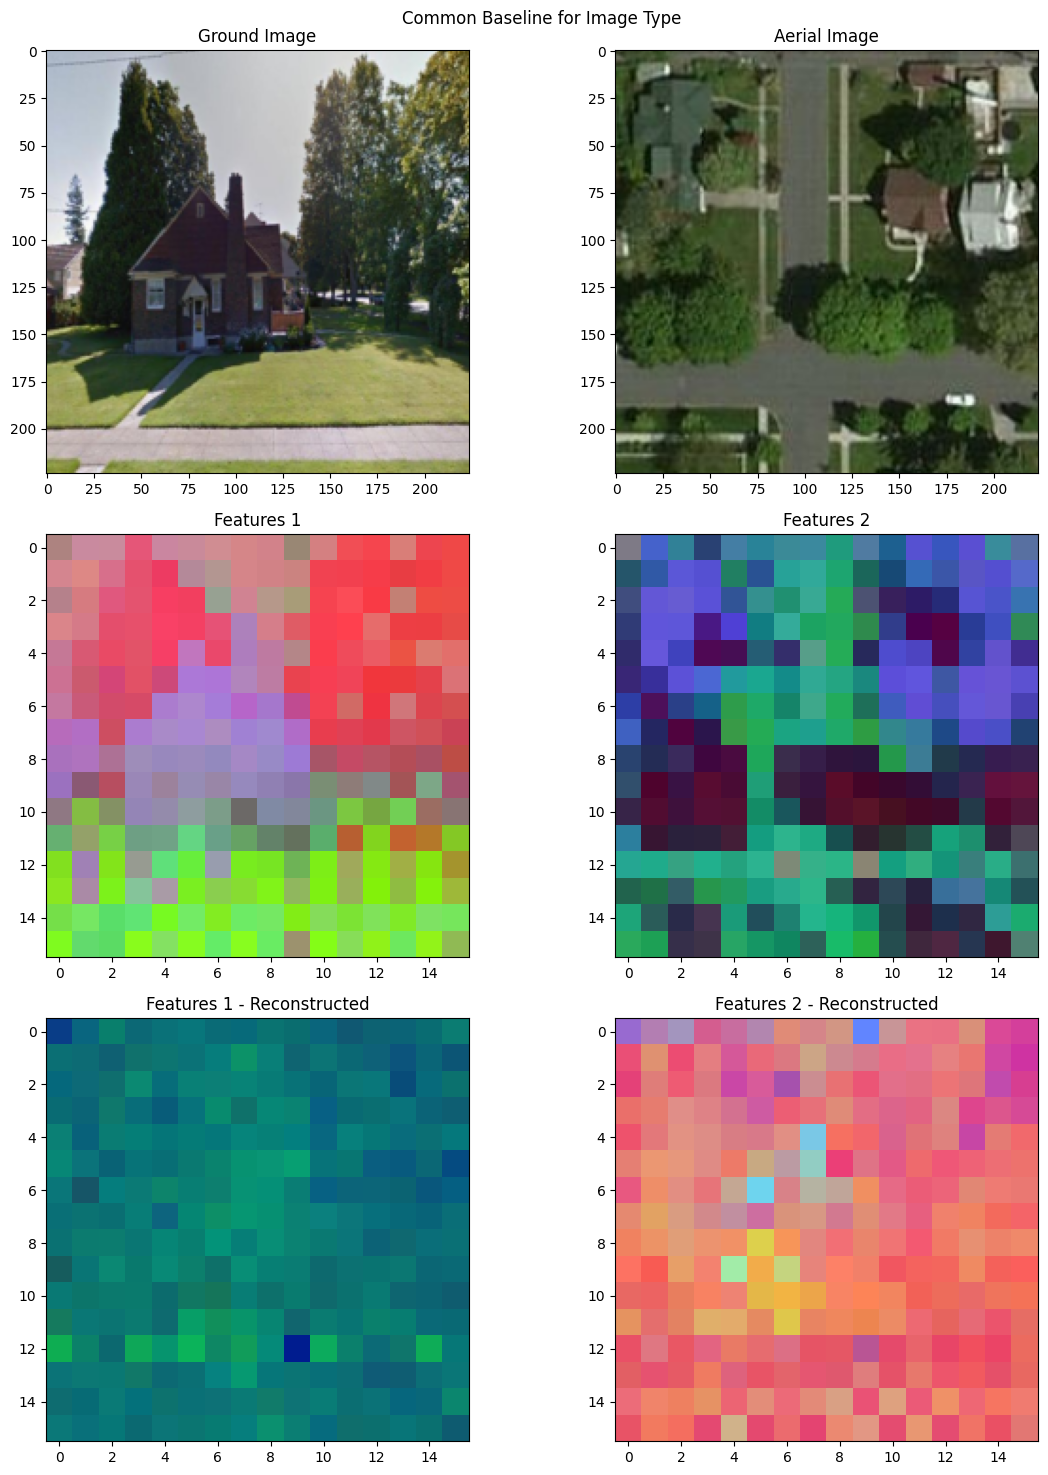

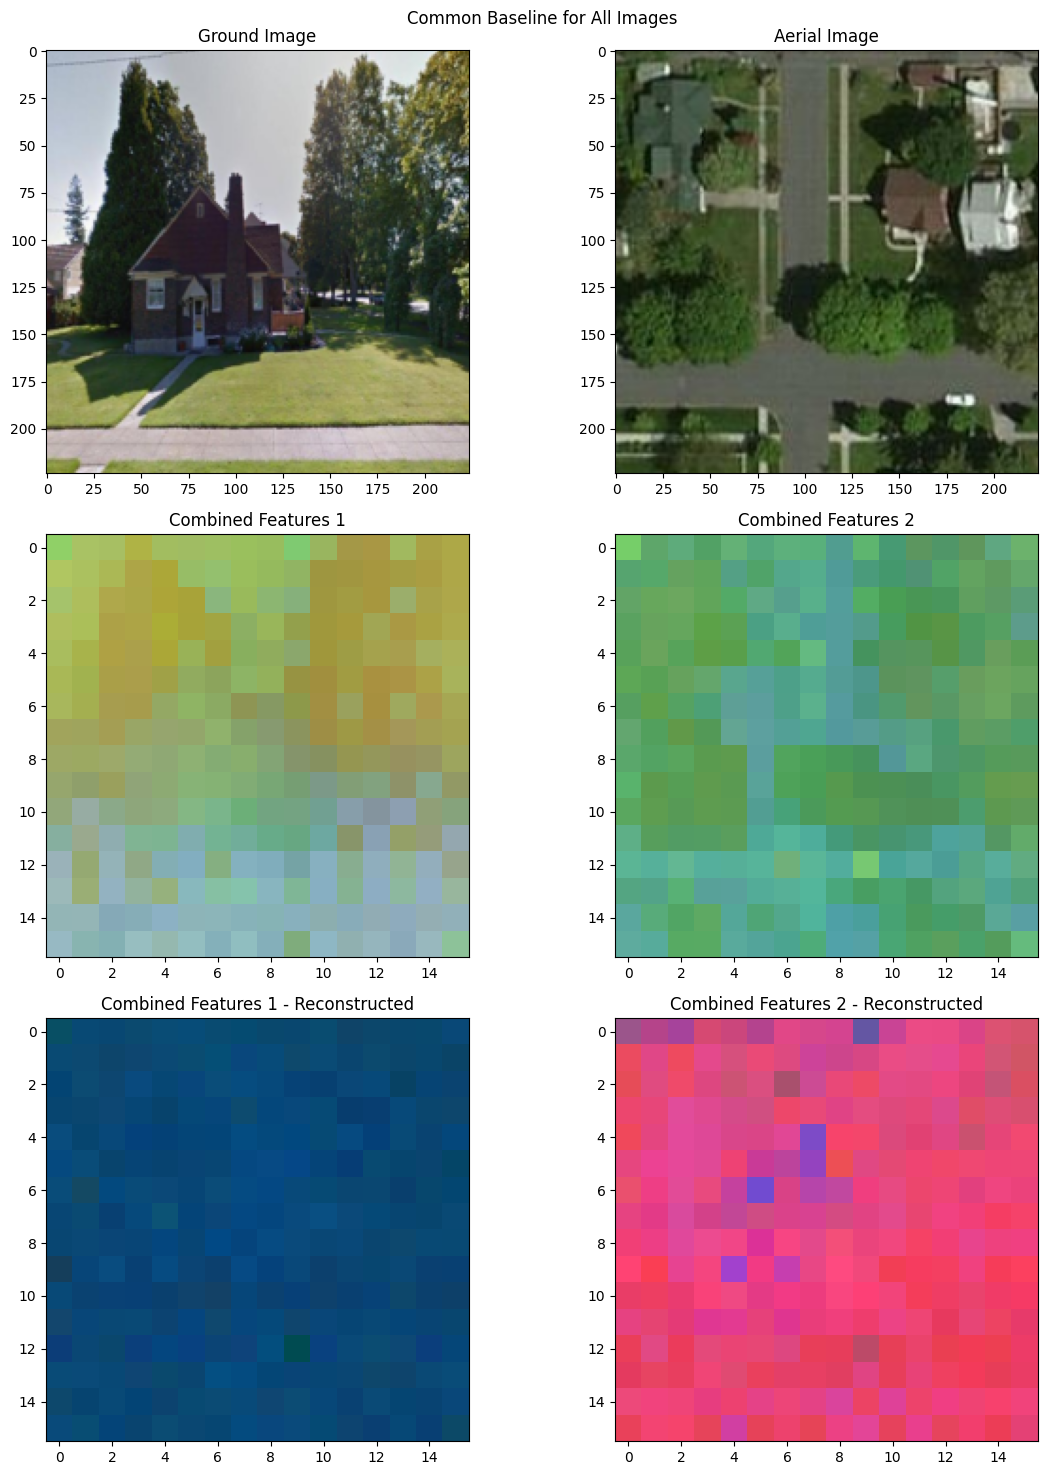

In [ ]:
ground_image_vis = ground_image.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255
aerial_image_vis = aerial_image.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255
ground_image_vis = ground_image_vis.astype(np.uint8)
aerial_image_vis = aerial_image_vis.astype(np.uint8)

# Init Dinov2Matcher
dm = Dinov2Matcher()

# Extract features
image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(ground_image_vis)
image_tensor2, grid_size2, resize_scale2 = dm.prepare_image(aerial_image_vis)
tokens_1 = ground_tokens.squeeze(0).detach().cpu().numpy()
tokens_2 = aerial_tokens.squeeze(0).detach().cpu().numpy()
grid_size4 = grid_size2
grid_size2_reduced = grid_size2
tokens_3 = reconstructed_ground.squeeze(0).detach().cpu().numpy()
tokens_4 = reconstructed_aerial.squeeze(0).detach().cpu().numpy()

# More info
print("ground_image shape:", ground_image.shape)
print("aerial_image shape:", aerial_image.shape)
print("tokens_1 shape:", tokens_1.shape)
print("tokens_2 shape:", tokens_2.shape)
print("grid_size1:", grid_size1)
print("grid_size2:", grid_size2)
print("grid_size2_reduced:", grid_size2_reduced)
print("resize_scale1:", resize_scale1)
print("resize_scale2:", resize_scale2)

# # Visualization - Baseline
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 15))
# ax1.imshow(ground_image_vis)
# ax1.set_title('Ground Image')
# ax2.imshow(aerial_image_vis)
# ax2.set_title('Aerial Image')
# vis_combined1, vis_combined2, vis_combined3, vis_combined4 = get_combined_embedding_visualization_all(dm.extract_features(image_tensor1), dm.extract_features(image_tensor2), tokens_1, tokens_2, grid_size1, grid_size2, grid_size1, grid_size2_reduced, debug=True)
# ax3.imshow(vis_combined1)
# ax3.set_title('Combined Features 1 - Reference')
# ax4.imshow(vis_combined2)
# ax4.set_title('Combined Features 2 - Reference')
# ax5.imshow(vis_combined3)
# ax5.set_title('Combined Features 1')
# ax6.imshow(vis_combined4)
# ax6.set_title('Combined Features 2')
# fig.suptitle("Common Baseline for All Images + Reference")
# fig.tight_layout()

# Visualization - Baseline
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 15))
ax1.imshow(ground_image_vis)
ax1.set_title('Ground Image')
ax2.imshow(aerial_image_vis)
ax2.set_title('Aerial Image')
vis_combined1, vis_combined2 = dm.get_combined_embedding_visualization(tokens_1, tokens_2, grid_size1, grid_size2_reduced)
vis_combined3, vis_combined4 = dm.get_combined_embedding_visualization(tokens_3, tokens_4, grid_size1, grid_size4)
ax3.imshow(vis_combined1)
ax3.set_title('Features 1')
ax4.imshow(vis_combined2)
ax4.set_title('Features 2')
ax5.imshow(vis_combined3)
ax5.set_title('Features 1 - Reconstructed')
ax6.imshow(vis_combined4)
ax6.set_title('Features 2 - Reconstructed')
fig.suptitle("Common Baseline for Image Row")
fig.tight_layout()

# Visualization - Reconstructed Images
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 15))
ax1.imshow(ground_image_vis)
ax1.set_title('Ground Image')
ax2.imshow(aerial_image_vis)
ax2.set_title('Aerial Image')
vis_combined1, vis_combined2, vis_combined3, vis_combined4 = get_combined_embedding_visualization_all(tokens_1, tokens_2, tokens_3, tokens_4, grid_size1, grid_size2, grid_size1, grid_size4, debug=True)
ax3.imshow(vis_combined1)
ax3.set_title('Combined Features 1')
ax4.imshow(vis_combined2)
ax4.set_title('Combined Features 2')
ax5.imshow(vis_combined3)
ax5.set_title('Combined Features 1 - Reconstructed')
ax6.imshow(vis_combined4)
ax6.set_title('Combined Features 2 - Reconstructed')
fig.suptitle("Common Baseline for All Images")
fig.tight_layout()

normalized_features1.shape: (256, 768)
normalized_features2.shape: (256, 768)
Selected index from aerial features:  229


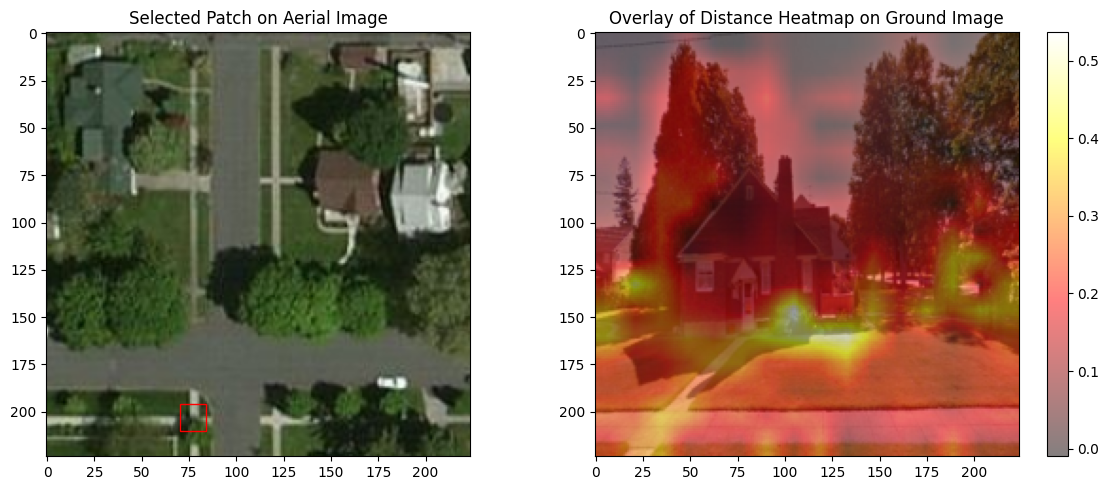

In [ ]:
from sklearn.preprocessing import normalize

# Normalize the features
normalized_features1 = normalize(tokens_1, axis=1)
normalized_features2 = normalize(tokens_2, axis=1)
print("normalized_features1.shape:", normalized_features1.shape)
print("normalized_features2.shape:", normalized_features2.shape)

# Take one element from features2 (aerial image features)
random_index = np.random.randint(0, tokens_2.shape[0])
selected_feature = normalized_features2[random_index]
print("Selected index from aerial features: ", random_index)

# Show which small piece of the aerial image was chosen
row_aerial, col_aerial = dm.idx_to_source_position(random_index, grid_size2, resize_scale2)
selected_patch_size = dm.model.patch_size * resize_scale2

# Compute the distance (inner product) between this element and all elements of features1 (ground image features)
distances = np.dot(normalized_features1, selected_feature)

# Reshape into the appropriate dimensions for the ground image
reshaped_distances = distances.reshape(grid_size1)

# Resize the heatmap to fit the ground image
resized_heatmap = cv2.resize(reshaped_distances, (ground_image_vis.shape[1], ground_image_vis.shape[0]))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(aerial_image_vis)
rect = plt.Rectangle((col_aerial - selected_patch_size / 2, row_aerial - selected_patch_size / 2),
                     selected_patch_size, selected_patch_size,
                     linewidth=1, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
ax1.set_title('Selected Patch on Aerial Image')
alpha = 0.5
ax2.imshow(ground_image_vis)
img2 = ax2.imshow(resized_heatmap, cmap='hot', interpolation='nearest', alpha=alpha)
fig.colorbar(img2, ax=ax2)
ax2.set_title('Overlay of Distance Heatmap on Ground Image')
fig.tight_layout()